[View in Colaboratory](https://colab.research.google.com/github/joheras/CLoDSA/blob/master/notebooks/CLODSA_Melanoma.ipynb)

# Augmenting a dataset for object classification

In this notebook, we illustrate how CLODSA can be employed to augment a dataset of images devoted to object classification. In particular, we use the dataset provided for the [ISBI 2017 challenge](http://biomedicalimaging.org/2017/challenges/): [Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#phase/5840f53ccad3a51cc66c8dab) - from now on we will call this dataset, the Melanoma dataset.

The Melanoma training dataset consists of 2000 dermoscopic images, including 374 "melanoma", 254 "seborrheic keratosis", and the remainder as benign nevi (1372). For illustration purposes, we take a subset of the Melanoma dataset containing 50 melanoma, 50 seborrheic keratosis and 100 benign nevi. Such a subset can be downloaded by executing the following command. 

In [1]:
!wget https://www.dropbox.com/s/oat7wljsuo7xsoc/subset.zip?dl=0 -O melanoma.zip
!unzip melanoma.zip

--2018-05-09 14:47:26--  https://www.dropbox.com/s/oat7wljsuo7xsoc/subset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/GATD0DpYZXglO9uh0LTKaXIX8J5JFhgFejstdkMK1y07T42A5Q0uOJlti2pGDNq0/file [following]
--2018-05-09 14:47:26--  https://dl.dropboxusercontent.com/content_link/GATD0DpYZXglO9uh0LTKaXIX8J5JFhgFejstdkMK1y07T42A5Q0uOJlti2pGDNq0/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601f:6::a27d:906
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.9.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249361286 (238M) [application/zip]
Saving to: ‘melanoma.zip’

melanoma.zip        100%[===================>] 237.81M  34.8MB/s    in 7.0s    

2018-05-09 14:47:3


  inflating: subset/seborrheic/ISIC_0012517.jpg  
  inflating: subset/seborrheic/ISIC_0012516.jpg  
  inflating: subset/seborrheic/ISIC_0012501.jpg  
  inflating: subset/seborrheic/ISIC_0012478.jpg  
  inflating: subset/seborrheic/ISIC_0012475.jpg  
  inflating: subset/seborrheic/ISIC_0012473.jpg  
  inflating: subset/seborrheic/ISIC_0012469.jpg  
  inflating: subset/seborrheic/ISIC_0012459.jpg  
  inflating: subset/seborrheic/ISIC_0012455.jpg  
  inflating: subset/seborrheic/ISIC_0012452.jpg  
  inflating: subset/seborrheic/ISIC_0012433.jpg  
  inflating: subset/seborrheic/ISIC_0012416.jpg  
  inflating: subset/seborrheic/ISIC_0012415.jpg  
  inflating: subset/seborrheic/ISIC_0012397.jpg  
  inflating: subset/seborrheic/ISIC_0012390.jpg  
  inflating: subset/seborrheic/ISIC_0012386.jpg  
  inflating: subset/seborrheic/ISIC_0012379.jpg  
  inflating: subset/seborrheic/ISIC_0012377.jpg  
  inflating: subset/seborrheic/ISIC_0012359.jpg  
  inflating: subset/seborrheic/ISIC_0012342.jpg  

We can check the amount of images in each one of the folders.

In [2]:
print("Number of images in melanoma folder")
!ls subset/melanoma/ | wc -l
print("Number of images in seborrheic folder")
!ls subset/seborrheic/ | wc -l
print("Number of images in nevus folder")
!ls subset/nevus/ | wc -l

Number of images in melanoma folder
50
Number of images in seborrheic folder
50
Number of images in nevus folder
100


## Augmentation techniques

Most of the top submissions employed to tackle the Melanoma dataset have applied some kind of data augmentation. For instance, the submission ["RECOD Titans at ISIC Challenge 2017"](https://arxiv.org/pdf/1703.04819.pdf)  employed horizontal and vertical shifts, and up to 270º degrees rotation; the submission ["A Novel Multi-task Deep Learning Model for Skin Lesion Segmentation and Classification"](https://arxiv.org/pdf/1703.01025.pdf) applied rotation and flipping; and, the submission ["Convolutional Neural Network Committees for Melanoma Classification with Classical And Expert Knowledge Based Image Transforms Data Augmentation"](https://arxiv.org/abs/1702.07025) used rotation, flipping, and cropping. In this notebook, we illustrate how the following augmentation techniques can be applied to the downloaded dataset:
- Vertical and horizontal flip.
- Rotation.
- Vertical and horizontal shifts.
- Crop. 

## Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [3]:
!pip install clodsa

    100% |████████████████████████████████| 1.5MB 6.6MB/s 
  Running setup.py bdist_wheel for clodsa ... - done
  Stored in directory: /content/.cache/pip/wheels/83/22/a6/25257fd393a89d9a6e51788f399e870e68c080454a992a3c07
  Running setup.py bdist_wheel for mahotas ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \

 | / done
  Stored in directory: /content/.cache/pip/wheels/ca/ed/a4/e7ca81cf5a4090f5a0a9d256fa98506902e4a25fe3e46b7907
  Running setup.py bdist_wheel for imutils ... - done
  Stored in directory: /content/.cache/pip/wheels/cb/58/9b/7debccbc53159611f67cc7e2e3ed37b217e56e9b40e7ba80c3
  Running setup.py bdist_wheel for commentjson ... - done
  Stored in directory: /content/.cache/pip/wheels/72/a3/90/047e693f33aa288b83e847dcdcb715fb72df1a9aa55b5cc728
Successfully built clodsa mahotas imutils commentjson


## Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA.

In [4]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.augmentors.generator import Generator
from clodsa.techniques.techniqueFactory import createTechnique
import cv2
%matplotlib inline

Using TensorFlow backend.


## Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, we are working in a classification problem

In [0]:
PROBLEM = "classification"

_The annotation mode_. The annotation is provided by the name of the folder containing the image. 

In [0]:
ANNOTATION_MODE = "folders"

_The input path_. The input path containing the images. 

In [0]:
INPUT_PATH = "subset/"

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [0]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called augmented_images.  

In [0]:
OUTPUT_MODE = "folders"
OUTPUT_PATH= "augmented_images/"

Using the above information, we can create our augmentor object. 

In [0]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})

## Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



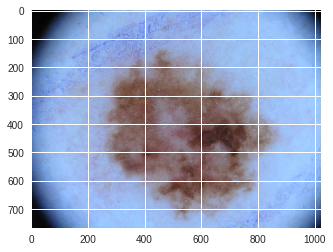

In [11]:
img = cv2.imread("subset/melanoma/ISIC_0000002.jpg")
# changing to the BGR format of OpenCV to RGB format for matplotlib
plt.imshow(img[:,:,::-1])

#### Vertical flip

In [0]:
vFlip = createTechnique("flip",{"flip":0})
augmentor.addGenerator(Generator(vFlip))

Showing the result of applying the transformation.

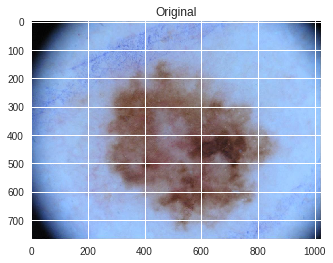

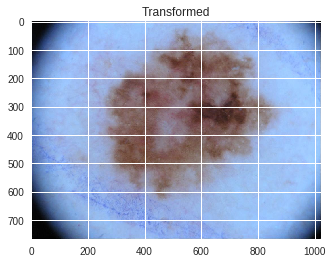

In [13]:
imgFlip = vFlip.apply(img)
plt.figure()
plt.title("Original")
plt.imshow(img[:,:,::-1])
plt.figure()
plt.title("Transformed")
plt.imshow(imgFlip[:,:,::-1])

#### Horizontal flip

In [0]:
hFlip = createTechnique("flip",{"flip":1})
augmentor.addGenerator(Generator(hFlip))

Showing the result of applying the transformation.

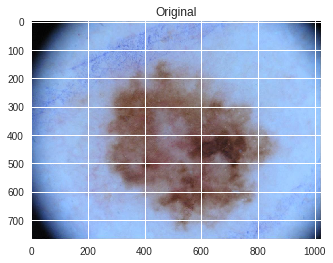

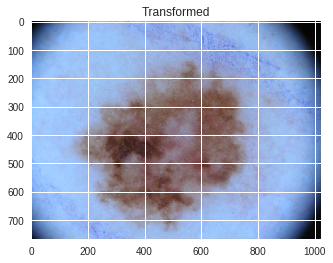

In [15]:
imgFlip = hFlip.apply(img)
plt.figure()
plt.title("Original")
plt.imshow(img[:,:,::-1])
plt.figure()
plt.title("Transformed")
plt.imshow(imgFlip[:,:,::-1])

_Rotations:_

In [0]:
rotateRandom = createTechnique("rotate",{})
augmentor.addGenerator(Generator(rotateRandom))
for angle in [90,180,270]:
    rotate = createTechnique("rotate", {"angle" : angle})
    augmentor.addGenerator(Generator(rotate))

Showing the result of applying the transformation.

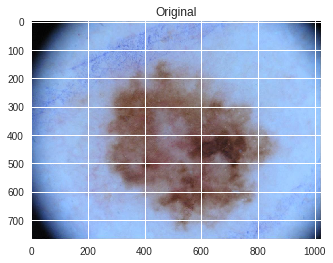

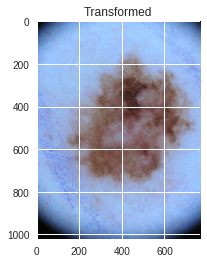

In [17]:
rotateImg = rotate.apply(img)
plt.figure()
plt.title("Original")
plt.imshow(img[:,:,::-1])
plt.figure()
plt.title("Transformed")
plt.imshow(rotateImg[:,:,::-1])

#### Crop

In [0]:
crop = createTechnique("crop",{"percentage":0.9,"startFrom": "TOPLEFT"})
augmentor.addGenerator(Generator(rotateRandom))

Showing the result of applying the transformation.

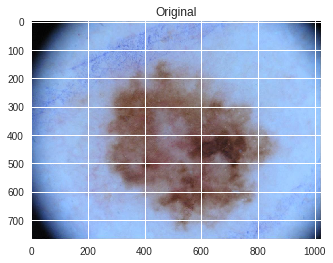

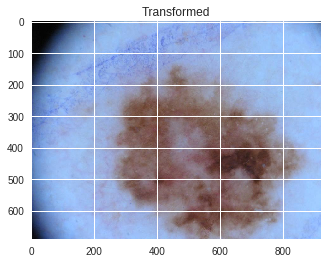

In [19]:
cropImg = crop.apply(img)
plt.figure()
plt.title("Original")
plt.imshow(img[:,:,::-1])
plt.figure()
plt.title("Transformed")
plt.imshow(cropImg[:,:,::-1])

#### Shifting

In [0]:
translation = createTechnique("translation", {"x":10,"y":10})
augmentor.addGenerator(Generator(translation))

Showing the result of applying the transformation.

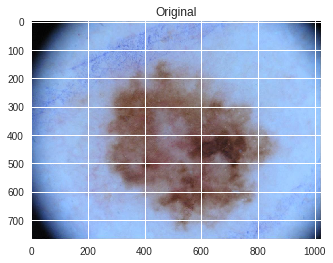

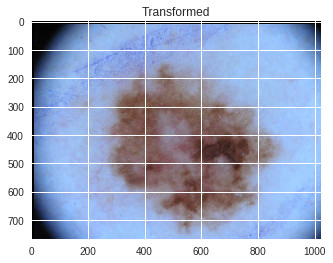

In [21]:
translatedImg = translation.apply(img)
plt.figure()
plt.title("Original")
plt.imshow(img[:,:,::-1])
plt.figure()
plt.title("Transformed")
plt.imshow(translatedImg[:,:,::-1])

#### None
(to keep also the original image)

In [0]:
none = createTechnique("none",{})
augmentor.addGenerator(Generator(none))

Showing the result of applying the transformation.

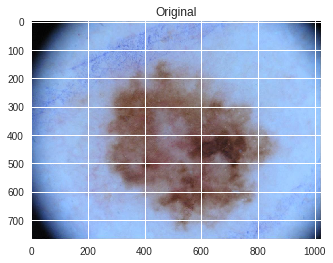

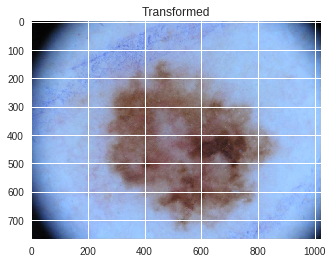

In [23]:
noneImg = none.apply(img)
plt.figure()
plt.title("Original")
plt.imshow(img[:,:,::-1])
plt.figure()
plt.title("Transformed")
plt.imshow(noneImg[:,:,::-1])

## Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [0]:
augmentor.applyAugmentation()

Finally, we can check the amount of images in the output folder.

In [0]:
print("Number of images in melanoma folder")
!ls augmented_images/melanoma/ | wc -l
print("Number of images in seborrheic folder")
!ls augmented_images/seborrheic/ | wc -l
print("Number of images in nevus folder")
!ls augmented_images/nevus/ | wc -l

If you are executing this notebook in Colaboratory, you need to download the generated files. To that aim, you can create a zip folder and download it using the following commands. 

In [0]:
!zip -r augmented_images.zip augmented_images
from google.colab import files
files.download('augmented_images.zip')